<a href="https://colab.research.google.com/github/sayan0506/Synthetic-Image-generation-using-VAE-/blob/main/Implement_VAE_using_Keras_backend_on_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### Installing livelossplot module for dynamical plot of model training


In [ ]:
!pip install git+git://github.com/stared/livelossplot.git

# Importing Modules

Importing nercessary modules, here we will implement the VAE using the tensorflow backend from scratch

In [ ]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

#from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from keras.layers import BatchNormalization
# importing keras functional api for neural network 
from tensorflow.keras.models import Model
# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial
from tensorflow.keras.datasets import fashion_mnist
# this keras backend will help to do some basic calculations or math stuffs
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# import keras and all the modules corresponding to to layers and alll using tensorflow.keras, else it's throwing errors

'''
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from keras.layers import BatchNormalization
# importing keras functional api for neural network 
from keras.models import Model
# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial
from keras.datasets import mnist
# this keras backend will help to do some basic calculations or math stuffs
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
'''

'\nimport keras\nfrom keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape\n# from keras.layers import BatchNormalization\n# importing keras functional api for neural network \nfrom keras.models import Model\n# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial\nfrom keras.datasets import mnist\n# this keras backend will help to do some basic calculations or math stuffs\nfrom keras import backend as K\nimport numpy as np\nfrom matplotlib import pyplot as plt\nfrom keras.utils.vis_utils import plot_model\n'

# Load Fashion_MNIST

Loading the train and test dataset of handwritten digits

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(f'Shape of the dataset: {x_train.shape}, {y_train.shape}, {x_test.shape}, {y_test.shape}')

Shape of the dataset: (60000, 28, 28), (60000,), (10000, 28, 28), (10000,)


# Data Pre-processing

## Normalizing the dataset

In [ ]:
# as VAE is a autoencoder based network, no need of classification information
# so we will only deal with the images
# converting the pixels to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalizing the dataset
x_train = x_train / 255.
x_test = x_test / 255.

## Reshaping the dataset

In [ ]:
# reshape the data
num_channels = 1
# reshaping the images to 4 dimensional space shape = (m, width, height, channels)
# skipped 1st 3 dimensions and adding new axis where we add channel axis
# for grayscale image channel = 1
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

# shape after reshaping
print(f'Reshaped size: {x_train.shape}, {x_test.shape}')

Reshaped size: (60000, 28, 28, 1), (10000, 28, 28, 1)


# Data Visualization

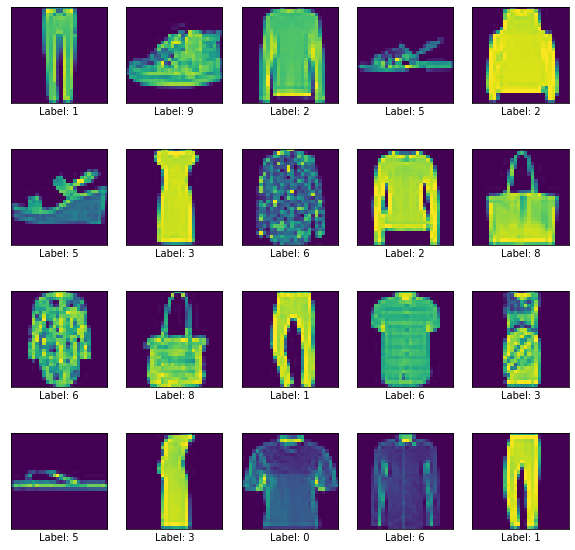

In [ ]:
# let ius visualzie 20 random sample training images

# rows = 4
r = 4
# columns = 5
c = 5

fig = plt.figure(figsize=(10,10))

for i in range(r * c):
  fig.add_subplot(r, c, i + 1)
  # random image no
  img_id = np.random.randint(0, x_train.shape[0])
  # np.squeeze the all unimportant dimensions, here m = 1, c = 1 for single image
  plt.imshow(np.squeeze(x_train[img_id]))
  #, cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'Label: {y_train[img_id]}')
  # plt.axis('off')

fig.show()

# Defining the parameters

In [46]:
# definingthe input image shape
img_width = x_train.shape[1]
img_height = x_train.shape[2]
input_img_shape = (img_width, img_height, num_channels)
 
# latent space dimension considered to be 2D here
latent_dim = 2

## Session Restart and Reinitialize(random-initialization) of internal variables and setup

In [148]:
# clears the previous training session, so that, current session is not being interrupted by the previous one
# so that internal variables in the present session is randomly initialized newly

tensorflow.keras.backend.clear_session()

# Building the Computational Graph of the Variational Autoencoder

* The variational autoencoder consists of encoder + latent_space + decoder
* The latent space consists of the combination of mean(mu) + std(sigma) layer
* We will use keras **Functional API** for the network

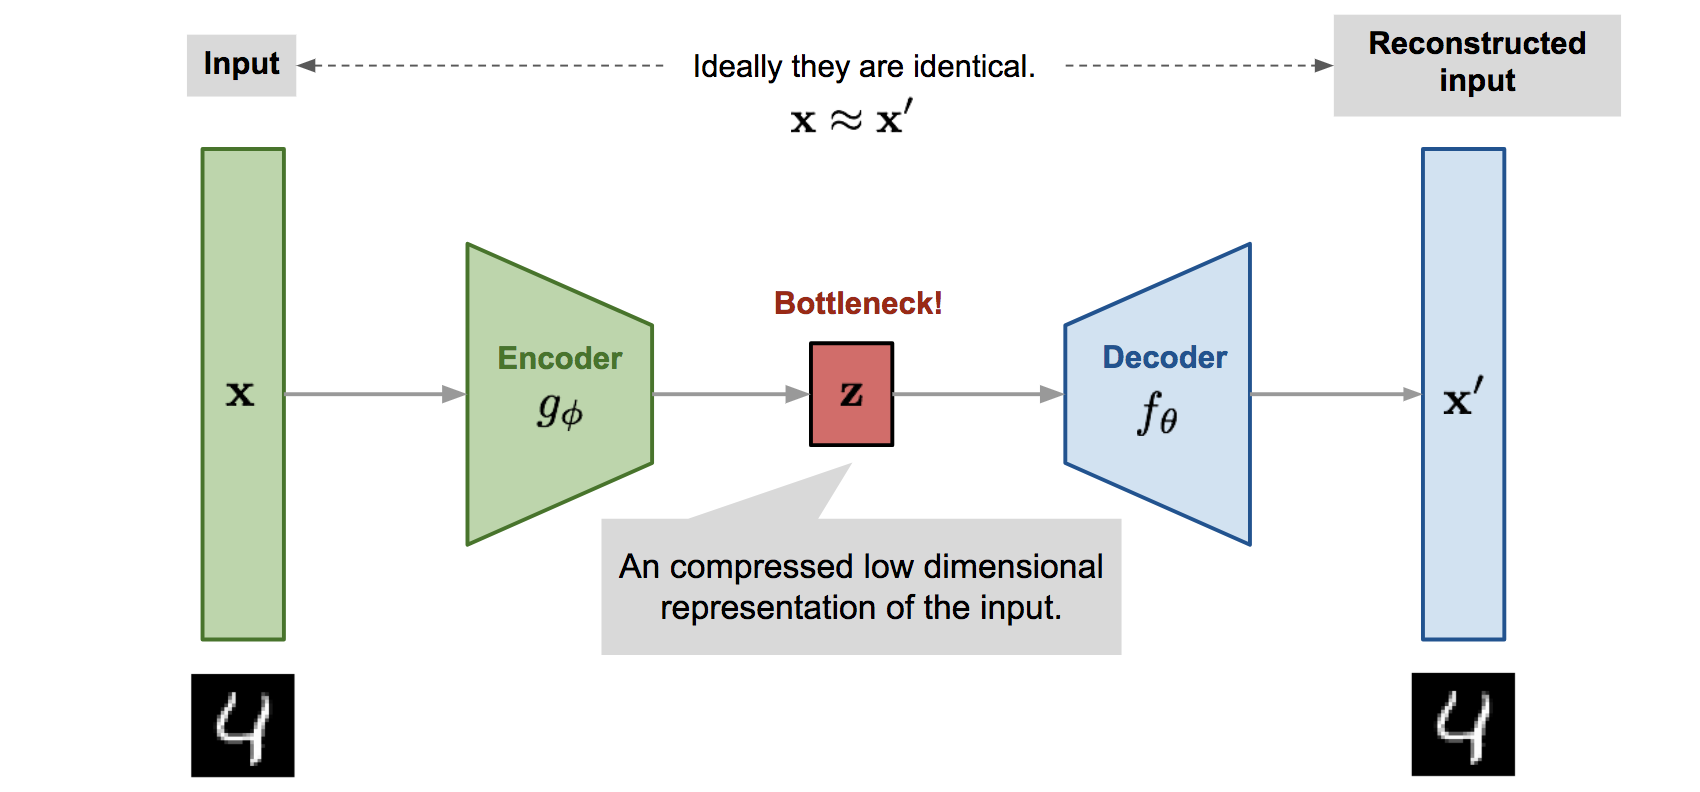

[image_link](https://www.google.com/url?sa=i&url=https%3A%2F%2Flilianweng.github.io%2Flil-log%2F2018%2F08%2F12%2Ffrom-autoencoder-to-beta-vae.html&psig=AOvVaw3-6qbk7x5xUZtop7SEl2sO&ust=1610287747220000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCKjrmZ-Dj-4CFQAAAAAdAAAAABAJ)

## Encoder section

* The encoder consists of 4 conv2d
* Then, the output is fed to a Flatten layer, then to a dense layer

In [149]:
# encoder convolution section
input_img = Input(shape = input_img_shape, name = 'VAE_encoder_input')
x = Conv2D(filters = 32, kernel_size= 3, padding='same', activation= 'relu')(input_img)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu', strides = (2,2))(x)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
x = Conv2D(filters = 64, kernel_size= 3, padding='same', activation= 'relu')(x)
                                                                                                                                                                                                                                                                                         
# As decoder reconstructs the image, so 1st convolution of decoder willbe transpose and having same shape as the 4th Conv2D
# shape of cnv2 to be provided to the decoder
conv_shape = K.int_shape(x)

# Flatten 
x = Flatten()(x)
# dense layer
x = Dense(32, activation = 'relu')(x)

# **Reparameterization Trick**

We need to do reparameterization for executing gradients inside the expectation variable correspond to the reconstruction loss of the variational lower bound, where we do a trasnformation for the latent space samples

> **z = mean_encoder_section + epsilon * sqrt(covariance matrix correspond to encoder section)**

* Here epsilon is the matrix which contains the random sample from the normal distribution N~(0,1) [That is the distribution we choose so that latent space can maintain it, which i regularized by the KL divergence term)

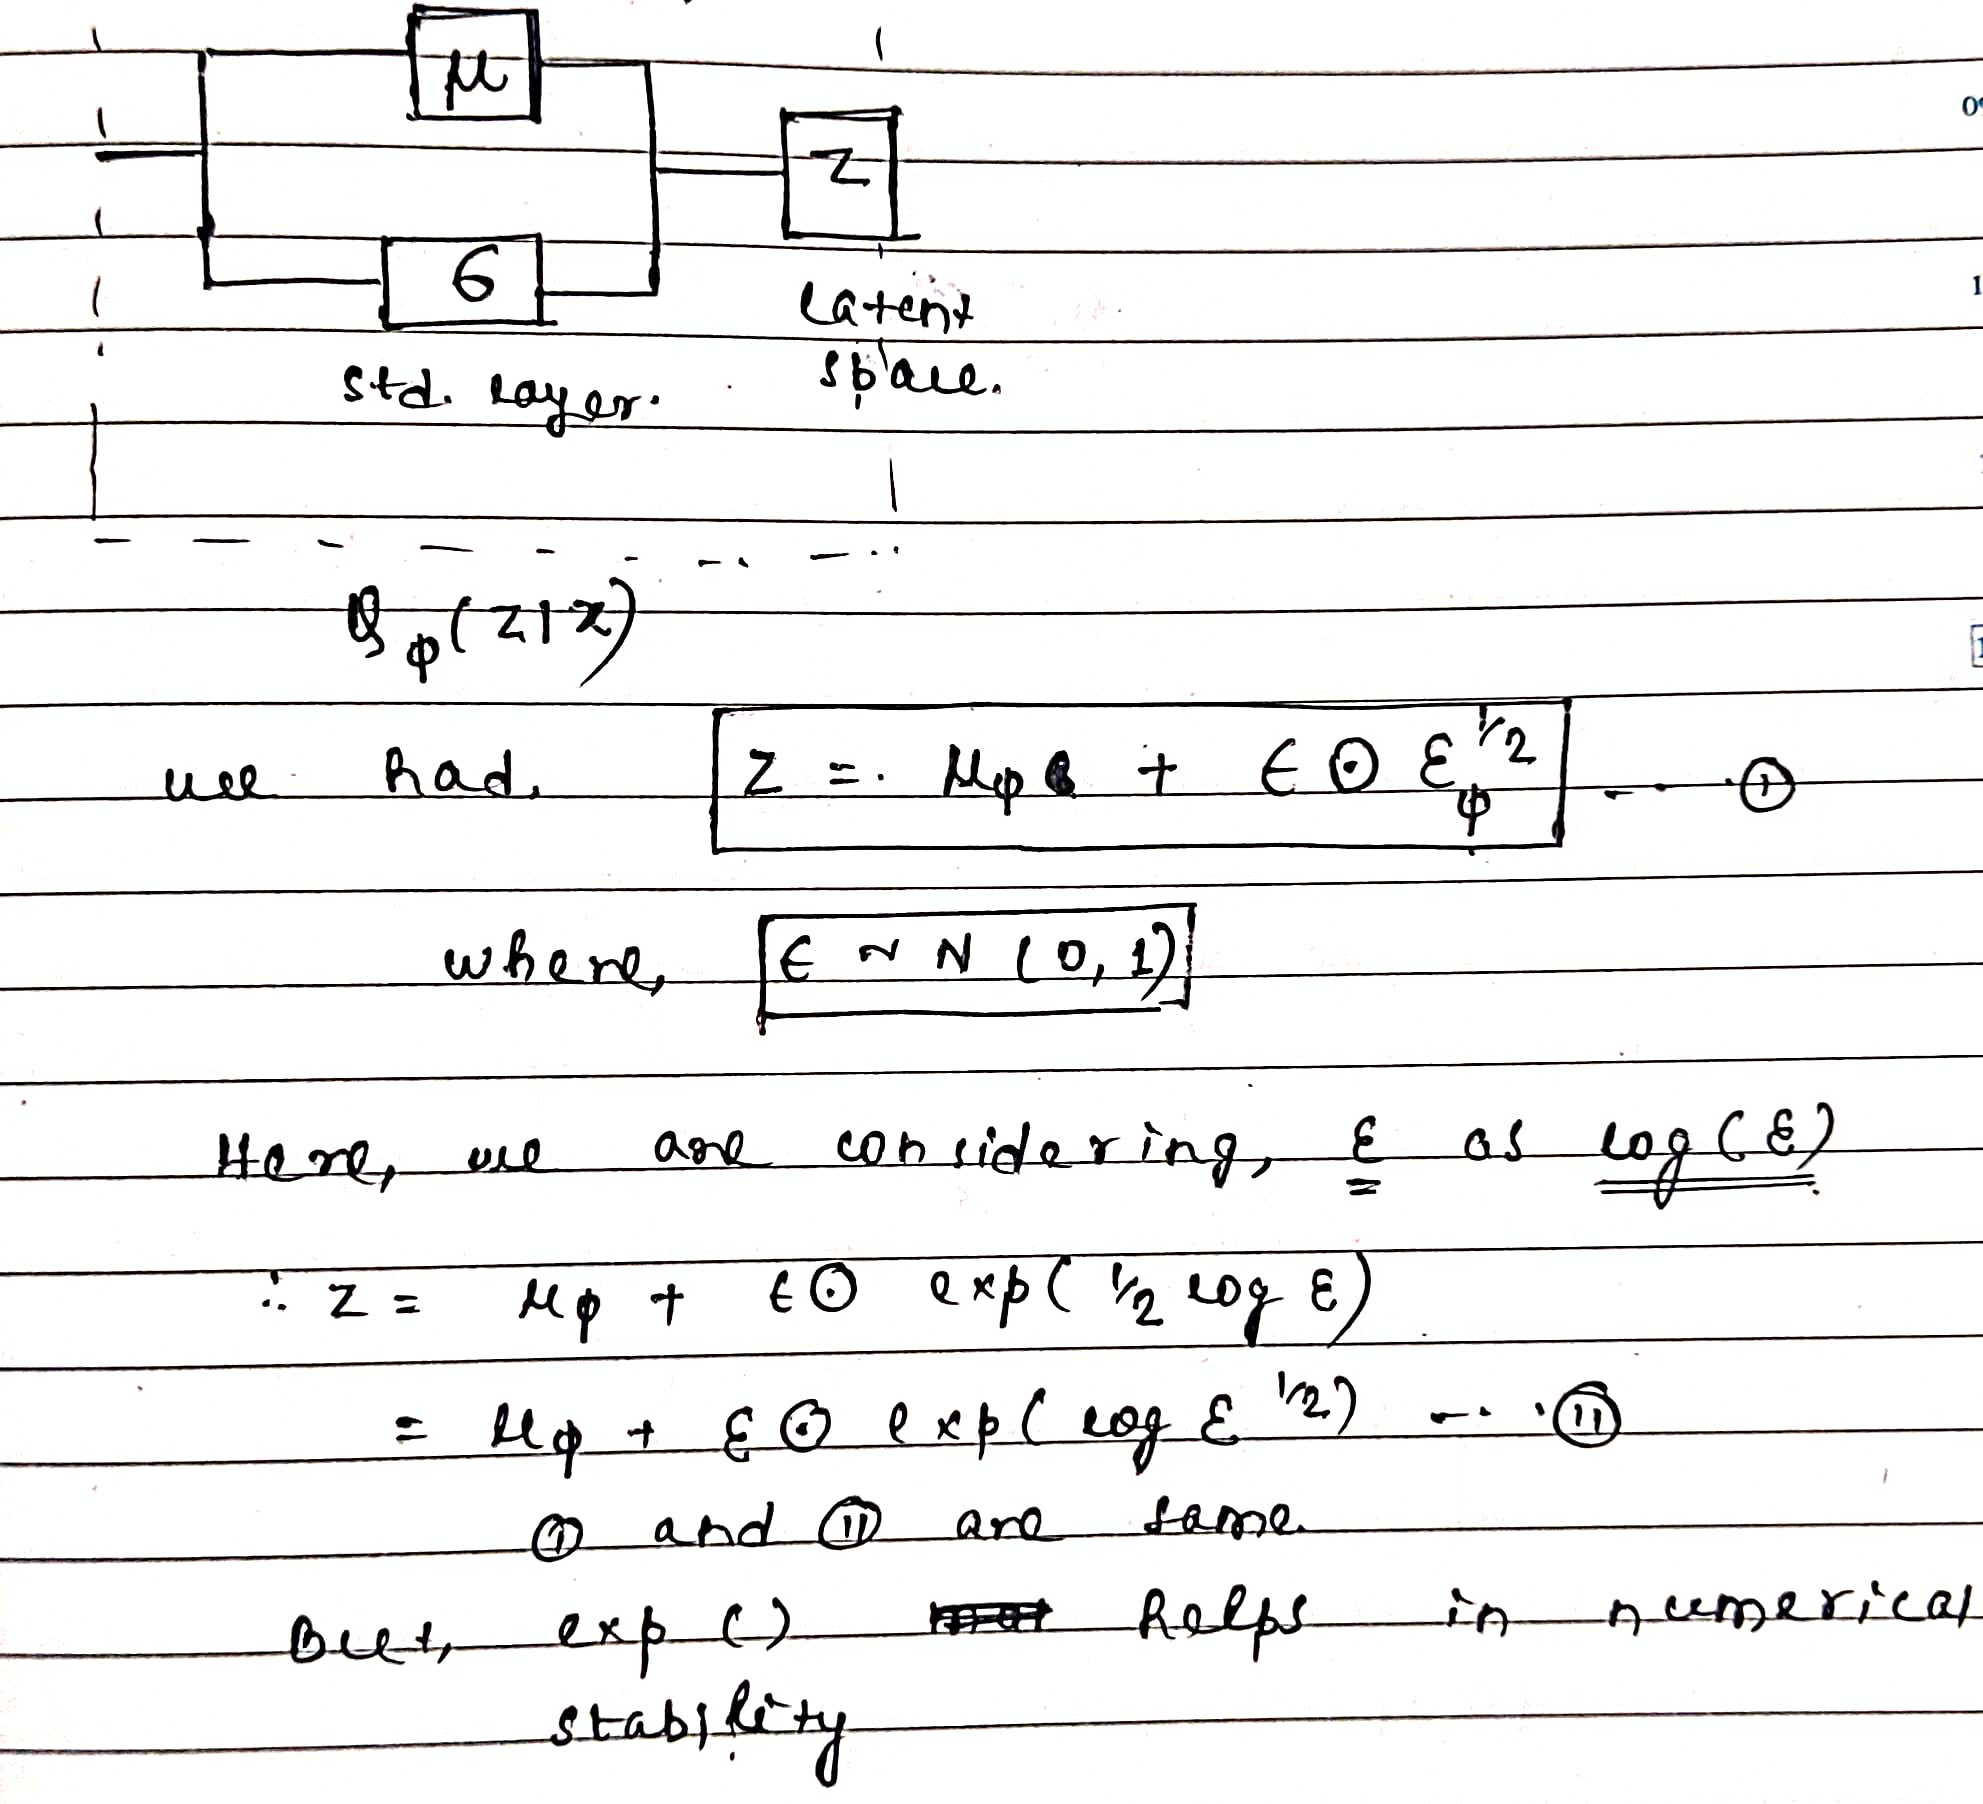

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

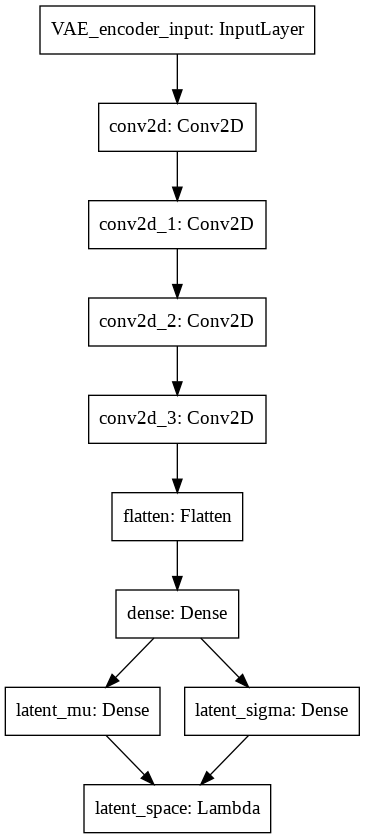

In [150]:
# mean layer
mean_layer = Dense(latent_dim, name = "latent_mu")(x)

# standard deviation hidden layer
std_layer = Dense(latent_dim, name = "latent_sigma")(x)

# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma * eps
# this is to allow gradient descent to estimate the gradients properly, or this helps to to make the z node from random to deterministic
# because we can't apply gradients on the stochastic node
def sample_z(args):
  z_mu, z_sigma = args
  batch_size = tensorflow.shape(z_mu)[0]
  # random samples from a normal distribution or a distribution we choose that the latent space should maintain
  epsilon = K.random_normal(shape = (batch_size, tensorflow.shape(z_sigma)[1]))
  # reparameterized z
  latent_z = z_mu + tensorflow.exp(1/2 * z_sigma) * epsilon
  return latent_z

# now in lambda latent layer we need to add the gradient descent calculation
# using mu and variance(sigma)
# in Lambda layer we pass the function_name
z = Lambda(sample_z, name = 'latent_space')([mean_layer, std_layer])

# Define and summarize the Encoder Model
encoder = Model(input_img, [mean_layer, std_layer, z], name = 'encoder')
# Model summary
encoder.summary()
# plotting the model
plot_model(encoder)

## Decoder *Section*

In [151]:
print(conv_shape)

(None, 14, 14, 64)


(None, 14, 14, 64)
(None, 28, 28, 32)
(None, 28, 28, 1)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


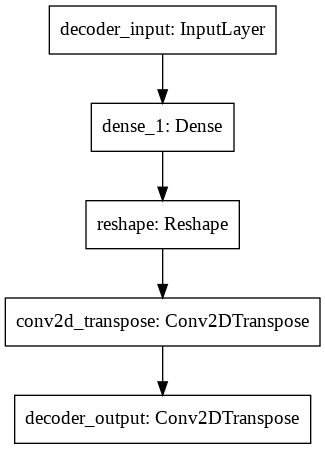

In [152]:
# decoder takes the latent vector as input
decoder_input = Input(shape = (latent_dim), name = 'decoder_input')

# we need the output from decoder_layer_1 will be same as the conv2D_4 input
# so add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshaping the output to feed to the conv2d layer in the decoder
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale back to original shape 
print(x.shape)
x = Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2,2))(x)
print(x.shape)
# returning back to recostructed image
x = Conv2DTranspose(num_channels, 3, padding = 'same', activation = 'sigmoid', name = 'decoder_output')(x)
print(x.shape)

# defining the decoder model using the functional api
decoder = Model(decoder_input, x, name = 'decoder')
decoder.summary()
plot_model(decoder)

We set the decoder layer 1 as input layer, the input layer receives the latent space layer as input attribute by defining the object of the decoder model using the keras functional api.

In [153]:
# apply the decoder to latent sample
print(z.shape)

z_decoded = decoder(z)
print(z_decoded.shape)
print(x)
print(z_decoded)

(None, 2)
(None, 28, 28, 1)
Tensor("decoder_output/Sigmoid:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("decoder/decoder_output/Sigmoid:0", shape=(None, 28, 28, 1), dtype=float32)


# Defining the custom loss layer of the VAE

We know, **variational lower bound = Reconstructional loss or log-likelihood or data-fidelity_loss term + KL divergence term or the regularizer**

Note: **Why we used model.add_loss?**

For your VAE example this is the case because the loss function also depends on additional tensors, namely z_log_var and z_mean, which are not available to the loss functions. Using model.add_loss() has no such restriction and allows you to write much more complex losses that depend on many other tensors, but it has the inconvenience of being more dependent on the model, whereas the standard loss functions work with just any model.

[link](https://stackoverflow.com/questions/50063613/what-is-the-purpose-of-the-add-loss-function-in-keras)

In [154]:
import tensorflow

# Define the custom loss
# VAE is trained using two loss functions reconstruction loss and KL divergence regulazrizer
# let us define a custom layer class using keras layer class api

class CustomLayer(tensorflow.keras.layers.Layer):
  
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    # reconstruction loss, (as we are using sigmoid, we can us binry cross-entropy)
    recon_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded)
    print(recon_loss.shape)
    # KL-divergence loss
    # K.mean implies mean across the variables of the latent space
    # axis = -1, as we are taking mean across the dimension of latent space, whose index is -1
    kl_loss = - 0.5 * K.mean(1 + std_layer - K.square(mean_layer) - K.exp(std_layer), axis = -1)
    print(kl_loss.shape)
    return K.mean(recon_loss + kl_loss)

  # add custom loss to the class
  # here we calling call function, at in python if the function name is call, it becomes callable with the instance of the class
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    # using the model.add_loss or here as it inherited to keras.layer.Layer class, so self.add_loss acts as model.add_loss
    # which helps to define any complex loss function also dependent on other parameters of the model apart from only y_true and y_pred
    self.add_loss(loss, inputs = inputs)
    return x


In [155]:
print(input_img)
print(encoder.input)
print(z_decoded)

Tensor("VAE_encoder_input:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("VAE_encoder_input:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("decoder/decoder_output/Sigmoid:0", shape=(None, 28, 28, 1), dtype=float32)


# Applying the custom loss to input images and decoded latent distribution sample

()
(None,)
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
_____________________________________________________________________________________

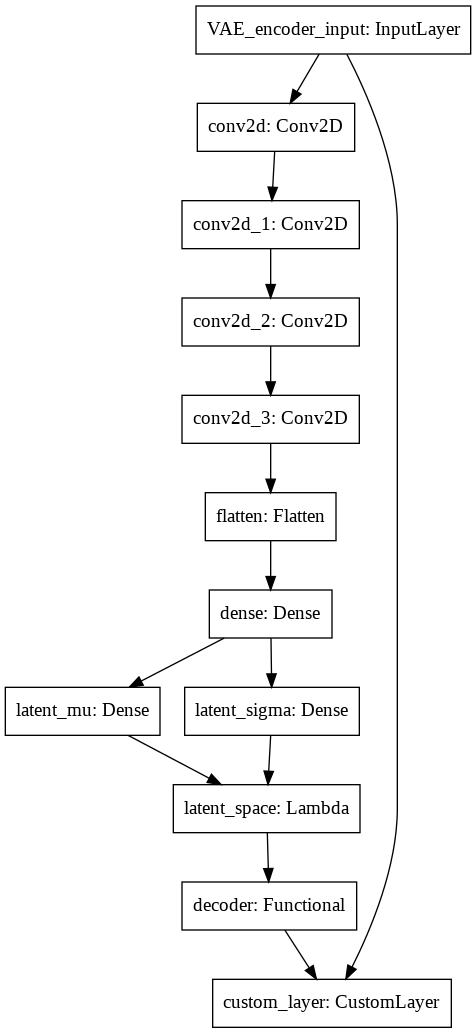

In [156]:
# here reconstruction loss is calculated between input_img and reconstructed por decoded image
y = CustomLayer()([input_img, z_decoded])
# y is the reconstructed image from the decoder

# VAE
vae = Model(input_img, y, name = 'VAE')
vae.summary()
plot_model(vae)

# Without using Loss Custom Layer

In [157]:
# Both the gates are set to 1 for the loss as variational lower bound(complete)

# the gate for reconstruction
recon_gate = 1

# the gate for KL divergence loss(here no KL term, so 0)
kl_loss_gate = 1


# here we are passing the custom loss function

def get_loss(distribution_mean, distribution_variance, recon_gate, kl_loss_gate):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return recon_gate * reconstruction_loss_batch + kl_loss_gate * kl_loss_batch
    
    return total_loss



# Building the VAE without using custom layer



Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_encoder_input (InputLayer)  [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         VAE_encoder_input[0][0]          
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
________________________________________________________________________________________________

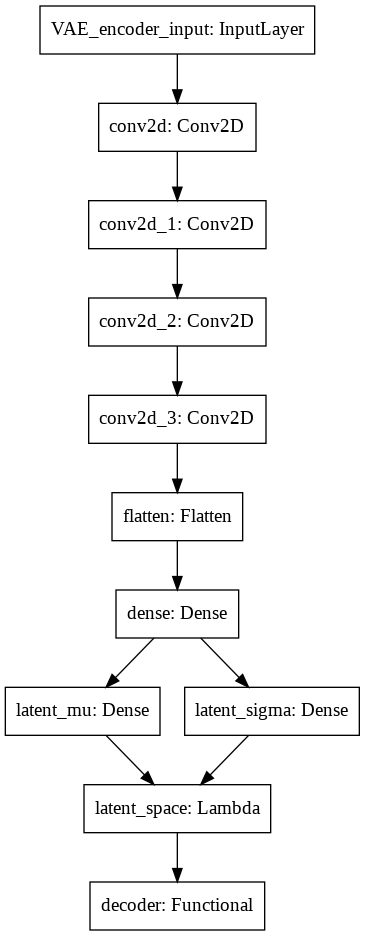

In [158]:
# VAE without custom layer(vae_wc)
vae_wc = Model(input_img, z_decoded, name = 'VAE')
vae_wc.summary()
plot_model(vae_wc)

**Syntax for compiling with custom layer**

In [129]:
vae.compile(optimizer='adam', loss = None)

**Syntax for with custom loss and without the custom loss layer**

Compiling the model using the ADAM optimizer using the learning rate 0.001

In [142]:
from tensorflow.keras.optimizers import Adam

learning_rate = 1e-03
vae_wc.compile(loss=get_loss(mean_layer, std_layer, recon_gate, kl_loss_gate), optimizer=Adam(learning_rate = learning_rate))

**PlotLossesCallback for live plot of model training**

In [95]:
# plotloss callback for dynamic training visualization
callbacks = [PlotLossesCallback()]

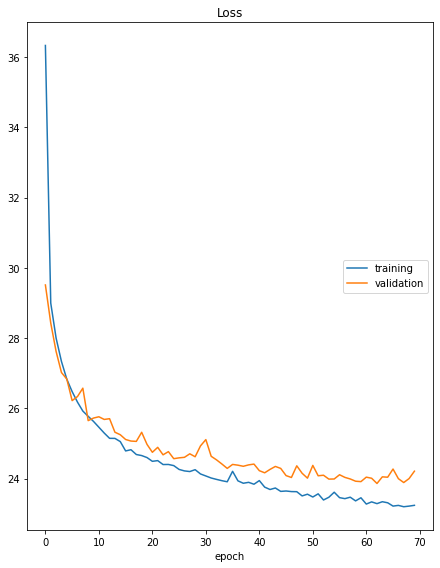

Loss
	training         	 (min:   23.201, max:   36.332, cur:   23.241)
	validation       	 (min:   23.863, max:   29.514, cur:   24.213)


In [96]:
vae_wc.fit(x_train, x_train, epochs=70, batch_size=64, validation_data=(x_test, x_test), callbacks= callbacks, verbose = 0)

# Recording the trained clustered 2D Latent space corresponding to the different category of fashion items

In [97]:
# storing the encoder learning output corresponding to 2D latent space, when complete variational lower bound loss is used
x1 = []
y1 = []
z1 = []
for i in range(10000):
    z1.append(y_test[i])
    # print(op.shape)
    op1 = encoder.predict(np.array([x_test[i]]))[2]
    x1.append(op1[0][0])
    y1.append(op1[0][1])

In [98]:
# shape of the encoder output
np.array(encoder.predict(np.array(x_test)))[2].shape

(10000, 2)

# Visualization of generated samples

Let us take values or encodings corresponding to 2D latent spaces

In [99]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

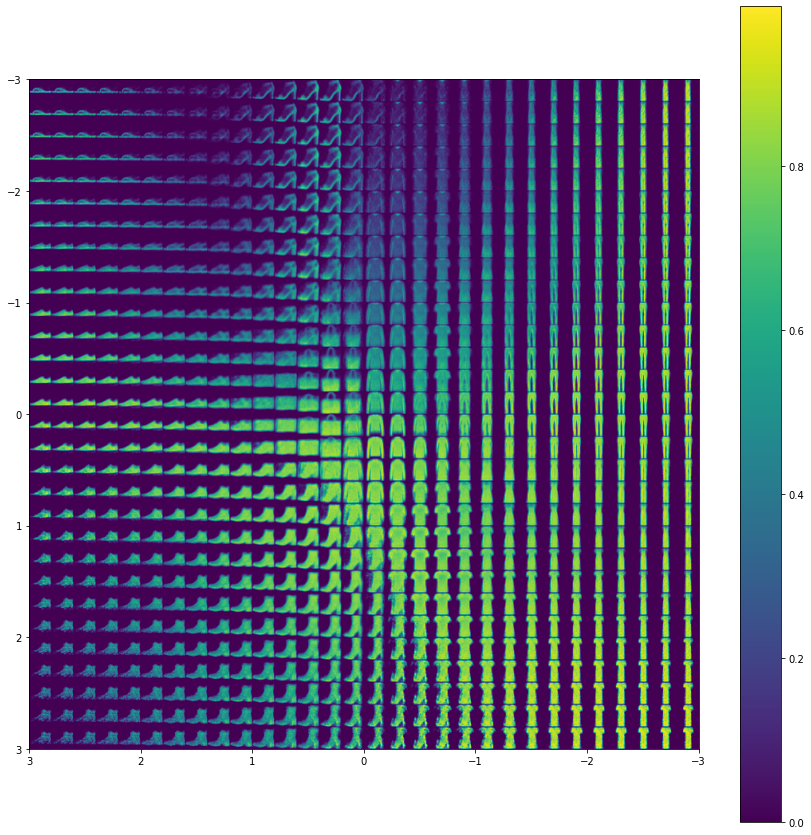

In [100]:
generator_model = decoder

figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[3,-3,3,-3])
plt.colorbar()
plt.show()

# Testing

Let us consider some conditions

>**1. Train the latent space without KL-divergence loss**
>
>**2. Train the latent space without Reconstruction loss**

Let us compare the result with the trained model with the complete **Variational Lower Bound loss** using the clustered visuaolization of 2D latent space

#### **Without KL-divergence loss**

In [143]:
from tensorflow.keras.optimizers import Adam

# The gate corresponding to reconstruction loss is set to 1 while gate for KL-loss is set to 0
# the gate for reconstruction
recon_gate = 1

# the gate for KL divergence loss(here no KL term, so 0)
kl_loss_gate = 0

# model compile
learning_rate = 1e-03
vae_wc.compile(loss=get_loss(mean_layer, std_layer, recon_gate, kl_loss_gate), optimizer=Adam(learning_rate = learning_rate))

# model training
vae_wc.fit(x_train, x_train, epochs=70, batch_size=64, validation_data=(x_test, x_test), verbose = 0)

In [144]:
# storing the encoder learning output corresponding to 2D latent space, when on reconstructiond loss is used
x2 = []
y2 = []
z2 = []
for i in range(10000):
    z2.append(y_test[i])
    # print(op.shape)
    op2 = encoder.predict(np.array([x_test[i]]))[2]
    x2.append(op2[0][0])
    y2.append(op2[0][1])

#### **Without Reconstruction loss**

In [159]:
from tensorflow.keras.optimizers import Adam

# The gate corresponding to reconstruction loss is set to 0 while gate for KL-loss is set to 1
# the gate for reconstruction
recon_gate = 0

# the gate for KL divergence loss(here no KL term, so 0)
kl_loss_gate = 1

# model compile
learning_rate = 1e-03
vae_wc.compile(loss=get_loss(mean_layer, std_layer, recon_gate, kl_loss_gate), optimizer=Adam(learning_rate = learning_rate))

# model training
vae_wc.fit(x_train, x_train, epochs=70, batch_size=64, validation_data=(x_test, x_test), verbose = 0)

In [160]:
# storing the encoder learning output corresponding to 2D latent space, when on reconstructiond loss is used
x3 = []
y3 = []
z3 = []
for i in range(10000):
    z3.append(y_test[i])
    # print(op.shape)
    op3 = encoder.predict(np.array([x_test[i]]))[2]
    x3.append(op3[0][0])
    y3.append(op3[0][1])

 ### **Comparison between 3 above mentioned conditions using clustered 2D latent space visualization**

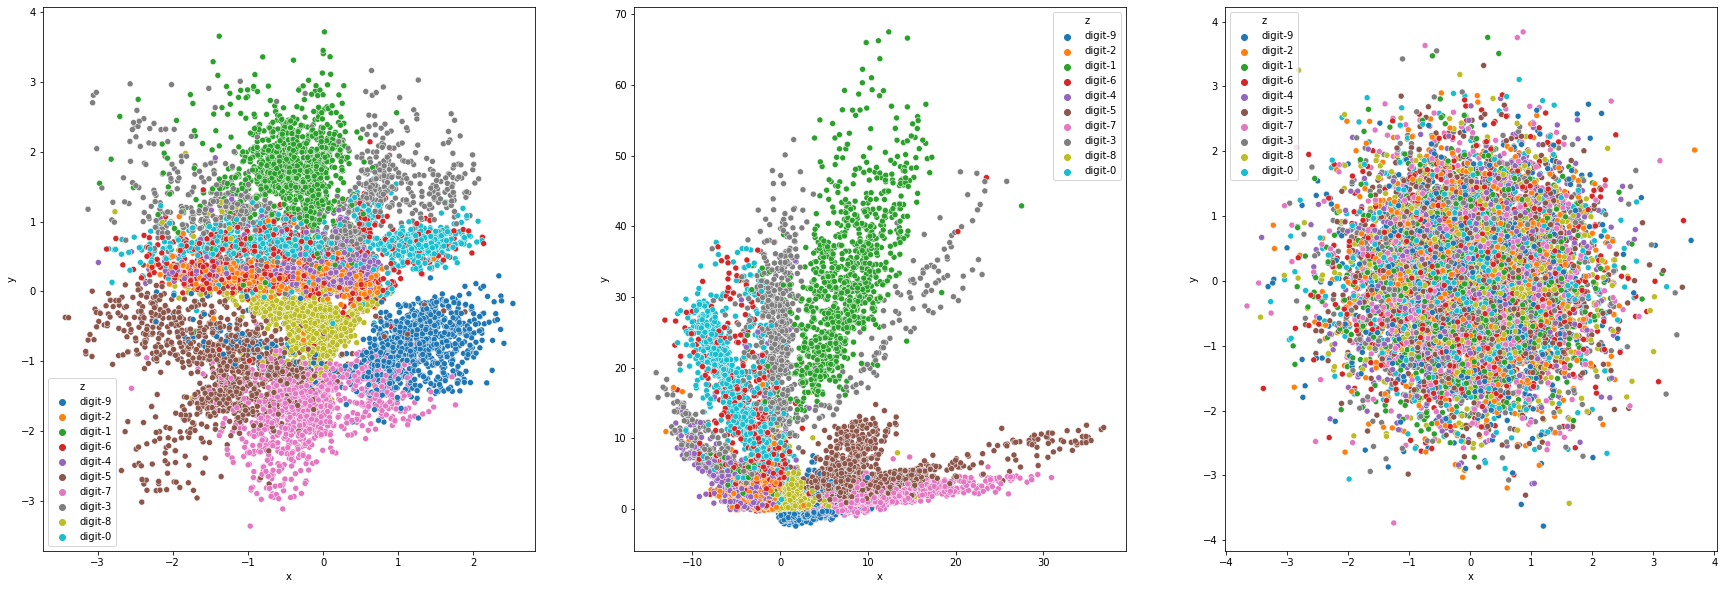

In [161]:
import pandas as pd
fig = plt.figure(figsize=(30, 10))

# plot for the clustered corresponding to complete variational lower bound
df = pd.DataFrame()
df['x'] = x1
df['y'] = y1
df['z'] = ["digit-"+str(k) for k in z1]
fig.add_subplot(1,3,1)
sns.scatterplot(x='x', y='y', hue='z', data=df)

# plot for the clustered corresponding to condition 1(without KL-divergence)
df = pd.DataFrame()
df['x'] = x2
df['y'] = y2
df['z'] = ["digit-"+str(k) for k in z2]
fig.add_subplot(1,3,2)
sns.scatterplot(x='x', y='y', hue='z', data=df)

# plot for the clustered corresponding condition 1(without Reconstruction loss)
df = pd.DataFrame()
df['x'] = x3
df['y'] = y3
df['z'] = ["digit-"+str(k) for k in z3]
fig.add_subplot(1,3,3)
sns.scatterplot(x='x', y='y', hue='z', data=df)

plt.show()
